# Student Exam Score Prediction

* Sandikha Rahardi (Kuldii Project)
* https://kuldiiproject.com

This notebook builds a machine learning solution to predict students' exam scores (math, reading, writing) based on their study-related features. The workflow includes EDA, preprocessing, model training, hyperparameter tuning, model comparison, and a Gradio interface for interactive predictions.

In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import sys
import shutil

import numpy as np
import gradio as gr
import pandas as pd
import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.multioutput import MultiOutputRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

## 2. Load Dataset

Download the dataset from [Kaggle](https://www.kaggle.com/datasets/spscientist/students-performance-in-exams/data) and place the CSV file in this project directory.

In [2]:
# Load the dataset using Kaggle API if not present
csv_file = 'StudentsPerformance.csv'
kaggle_dataset = 'spscientist/students-performance-in-exams'

if not os.path.exists('datasets/'+csv_file):
    # Install kaggle if needed
    try:
        import kaggle
    except ImportError:
        !{sys.executable} -m pip install kaggle
    # Set up Kaggle API credentials
    kaggle_json_path = os.path.expanduser('~/.kaggle/kaggle.json')
    if not os.path.exists(kaggle_json_path):
        shutil.copy('kaggle.json', kaggle_json_path)
    os.chmod(kaggle_json_path, 0o600)
    # Download dataset
    !kaggle datasets download -d {kaggle_dataset} --unzip -p datasets
    print(f"Extracted {csv_file}")
else:
    print(f"{csv_file} already exists.")

StudentsPerformance.csv already exists.


In [3]:
df = pd.read_csv('datasets/'+csv_file)
df

,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75
...,...,...,...,...,...,...,...,...
995,female,group E,master's degree,standard,completed,88,99,95
996,male,group C,high school,free/reduced,none,62,55,55
997,female,group C,high school,free/reduced,completed,59,71,65
998,female,group D,some college,standard,completed,68,78,77


## 3. Exploratory Data Analysis (EDA)

Let's explore the dataset: view the first and last rows, shape, info, summary statistics, and check for missing values.

In [4]:
# Basic EDA
print('First 5 rows:')
display(df.head())
print('Last 5 rows:')
display(df.tail())
print(f'Shape: {df.shape}')
print('\nInfo:')
df.info()
print('\nDescribe:')
display(df.describe())
print('\nMissing values:')
display(df.isnull().sum())

First 5 rows:


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
0,female,group B,bachelor's degree,standard,none,72,72,74
1,female,group C,some college,standard,completed,69,90,88
2,female,group B,master's degree,standard,none,90,95,93
3,male,group A,associate's degree,free/reduced,none,47,57,44
4,male,group C,some college,standard,none,76,78,75


Last 5 rows:


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
995,female,group E,master's degree,standard,completed,88,99,95
996,male,group C,high school,free/reduced,none,62,55,55
997,female,group C,high school,free/reduced,completed,59,71,65
998,female,group D,some college,standard,completed,68,78,77
999,female,group D,some college,free/reduced,none,77,86,86


Shape: (1000, 8)

Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   gender                       1000 non-null   object
 1   race/ethnicity               1000 non-null   object
 2   parental level of education  1000 non-null   object
 3   lunch                        1000 non-null   object
 4   test preparation course      1000 non-null   object
 5   math score                   1000 non-null   int64 
 6   reading score                1000 non-null   int64 
 7   writing score                1000 non-null   int64 
dtypes: int64(3), object(5)
memory usage: 62.6+ KB

Describe:


,math score,reading score,writing score
count,1000.00000,1000.000000,1000.000000
mean,66.08900,69.169000,68.054000
std,15.16308,14.600192,15.195657
min,0.00000,17.000000,10.000000
25%,57.00000,59.000000,57.750000
50%,66.00000,70.000000,69.000000
75%,77.00000,79.000000,79.000000
max,100.00000,100.000000,100.000000



Missing values:


gender                         0
race/ethnicity                 0
parental level of education    0
lunch                          0
test preparation course        0
math score                     0
reading score                  0
writing score                  0
dtype: int64


gender unique values:
gender
female    518
male      482
Name: count, dtype: int64


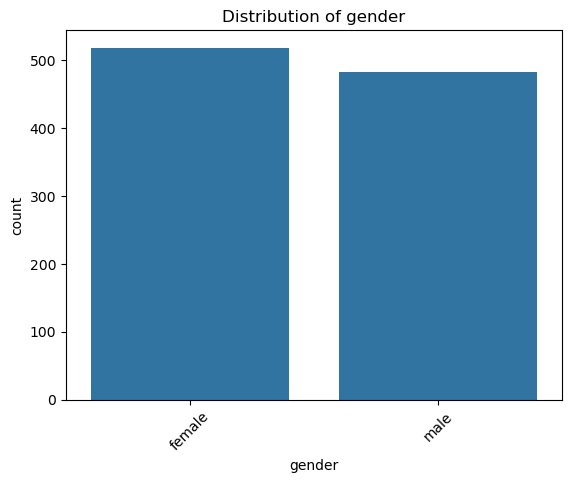


race/ethnicity unique values:
race/ethnicity
group C    319
group D    262
group B    190
group E    140
group A     89
Name: count, dtype: int64


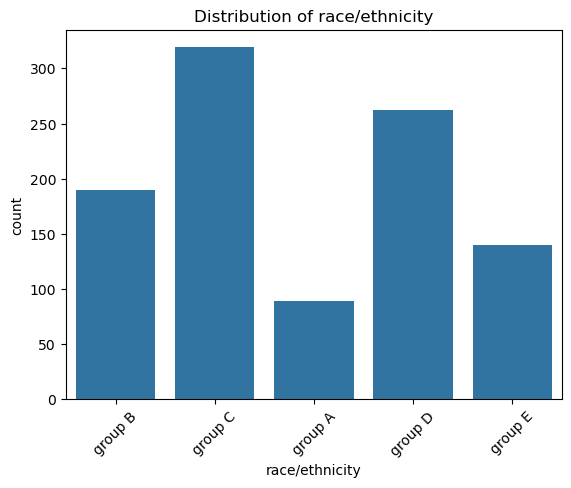


parental level of education unique values:
parental level of education
some college          226
associate's degree    222
high school           196
some high school      179
bachelor's degree     118
master's degree        59
Name: count, dtype: int64


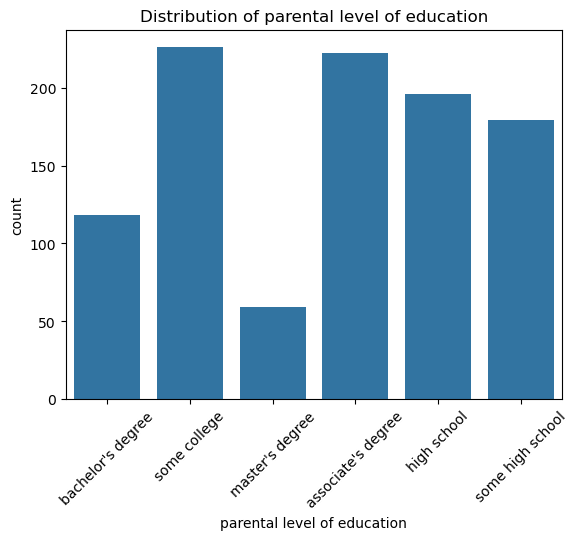


lunch unique values:
lunch
standard        645
free/reduced    355
Name: count, dtype: int64


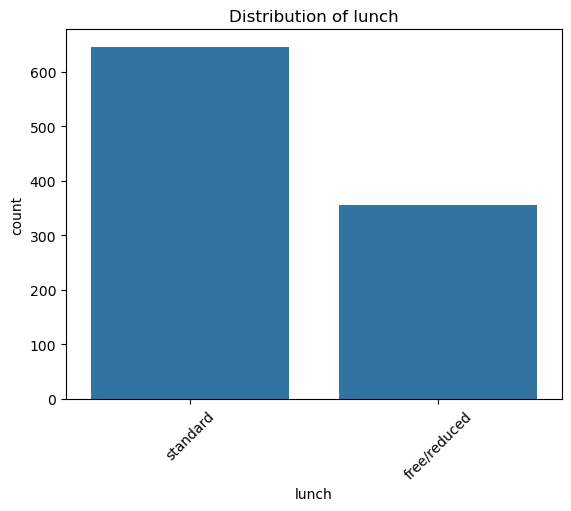


test preparation course unique values:
test preparation course
none         642
completed    358
Name: count, dtype: int64


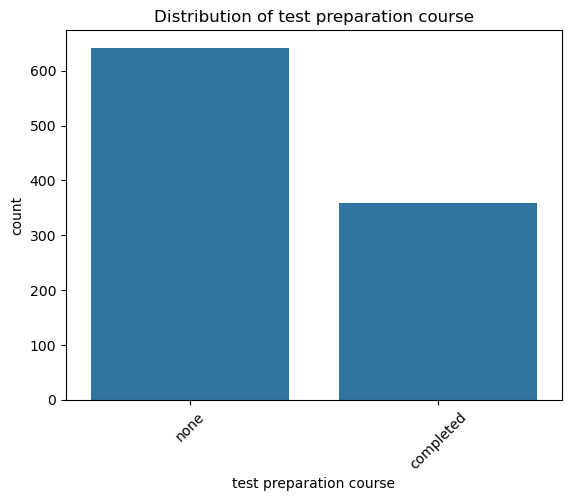

In [5]:
# Analyze categorical variables
categorical_features = ['gender', 'race/ethnicity', 'parental level of education', 'lunch', 'test preparation course']

for col in categorical_features:
    print(f'\n{col} unique values:')
    print(df[col].value_counts())
    sns.countplot(data=df, x=col)
    plt.title(f'Distribution of {col}')
    plt.xticks(rotation=45)
    plt.show()

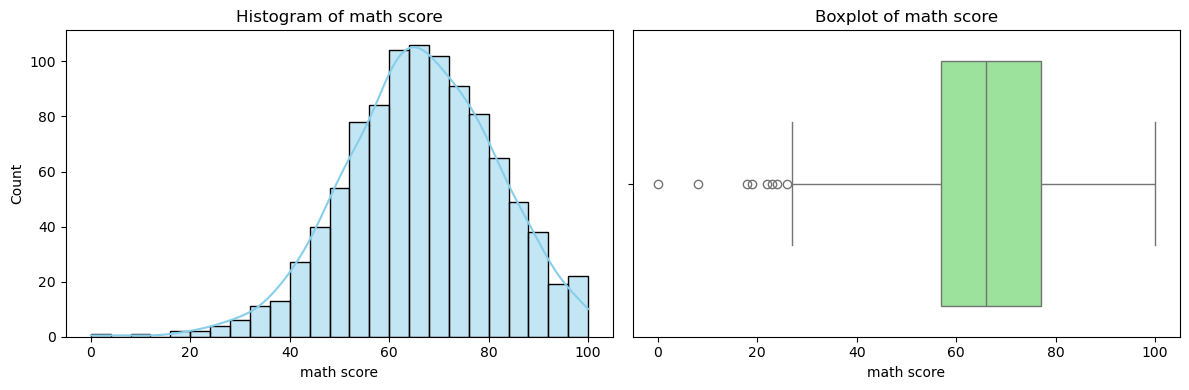

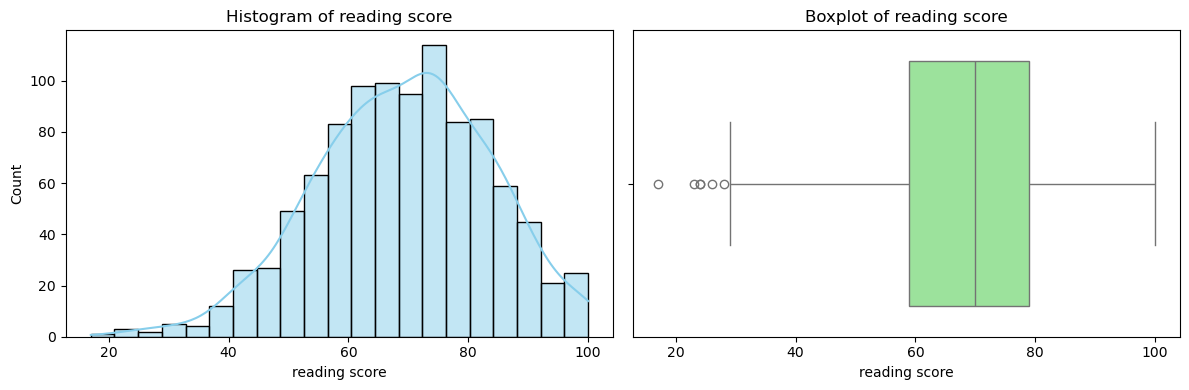

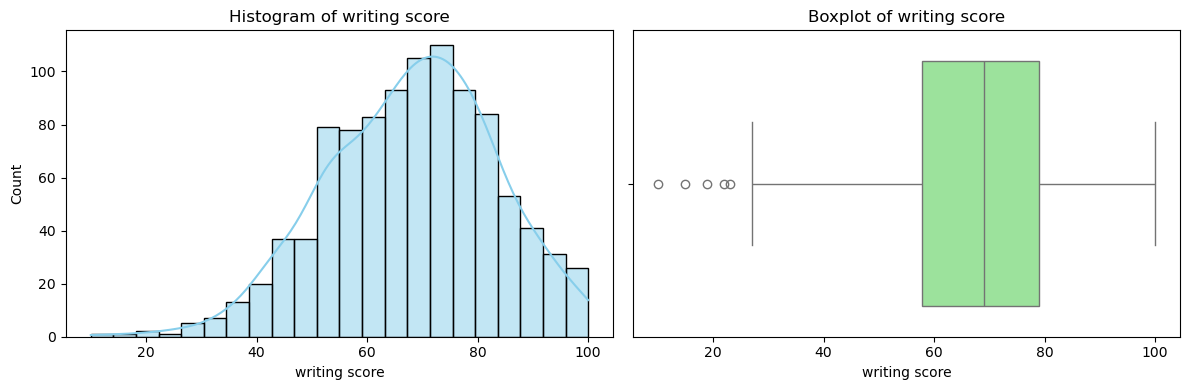

In [6]:
# Analyze target variables: histograms and boxplots
score_columns = ['math score', 'reading score', 'writing score']

for col in score_columns:
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))
    sns.histplot(df[col], kde=True, ax=axes[0], color='skyblue')
    axes[0].set_title(f'Histogram of {col}')
    sns.boxplot(x=df[col], ax=axes[1], color='lightgreen')
    axes[1].set_title(f'Boxplot of {col}')
    plt.tight_layout()
    plt.show()

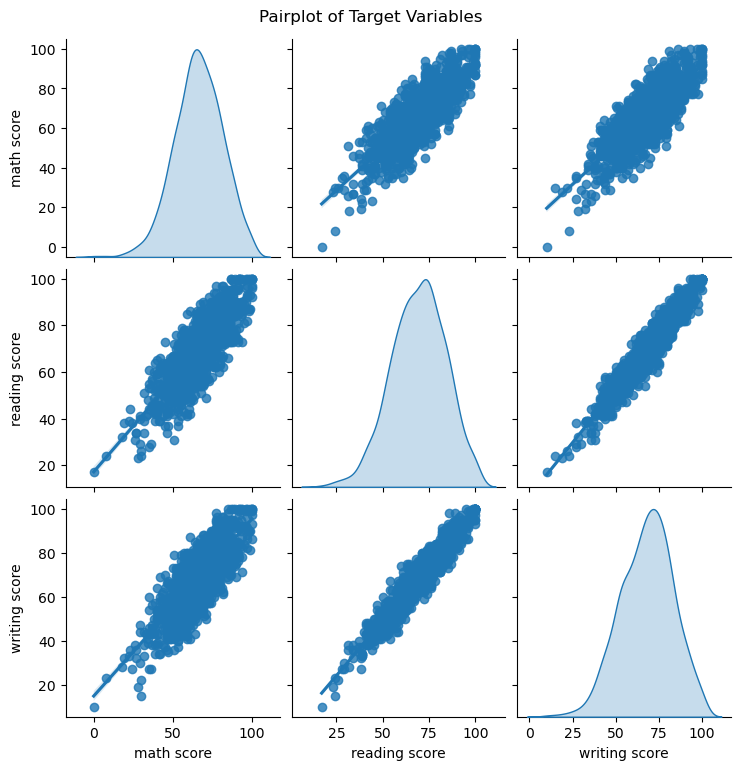

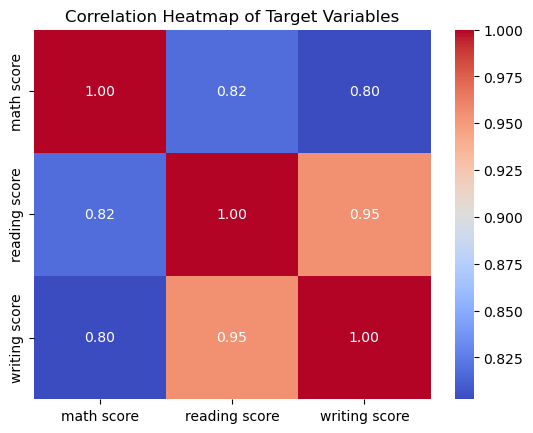

In [7]:
# Pairplot of target variables
sns.pairplot(df[score_columns], kind='reg', diag_kind='kde')
plt.suptitle('Pairplot of Target Variables', y=1.02)
plt.show()

# Correlation heatmap
corr = df[score_columns].corr()
sns.heatmap(corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap of Target Variables')
plt.show()


Average scores grouped by gender:


,math score,reading score,writing score
gender,,,
female,63.633205,72.608108,72.467181
male,68.728216,65.473029,63.311203


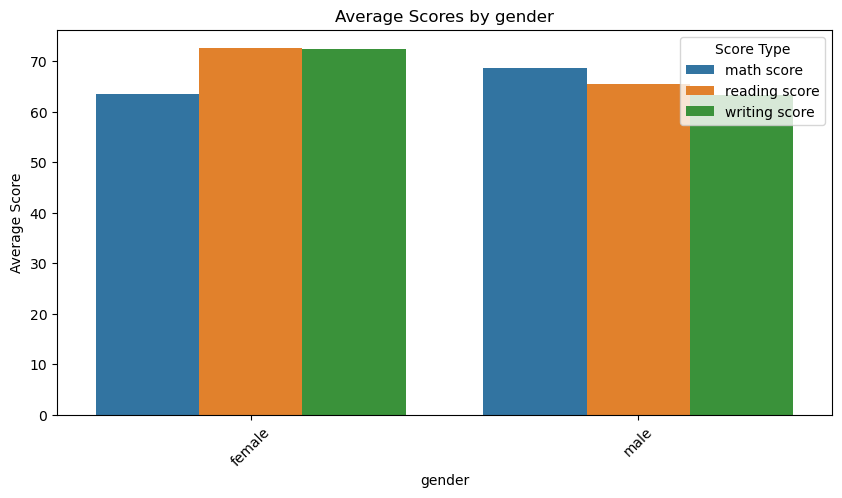

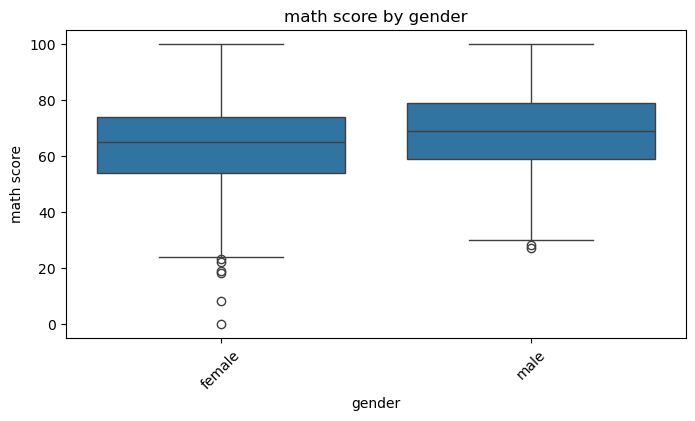

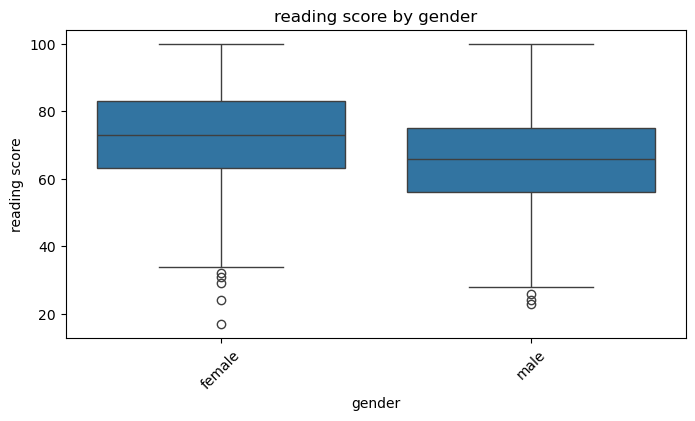

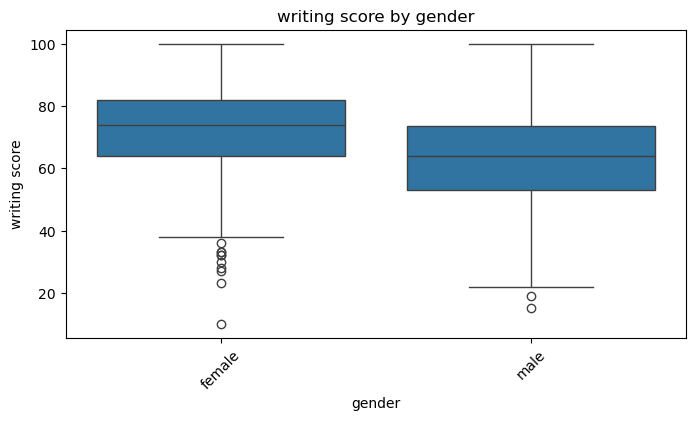


Average scores grouped by race/ethnicity:


,math score,reading score,writing score
race/ethnicity,,,
group A,61.629213,64.674157,62.674157
group B,63.452632,67.352632,65.600000
group C,64.463950,69.103448,67.827586
group D,67.362595,70.030534,70.145038
group E,73.821429,73.028571,71.407143


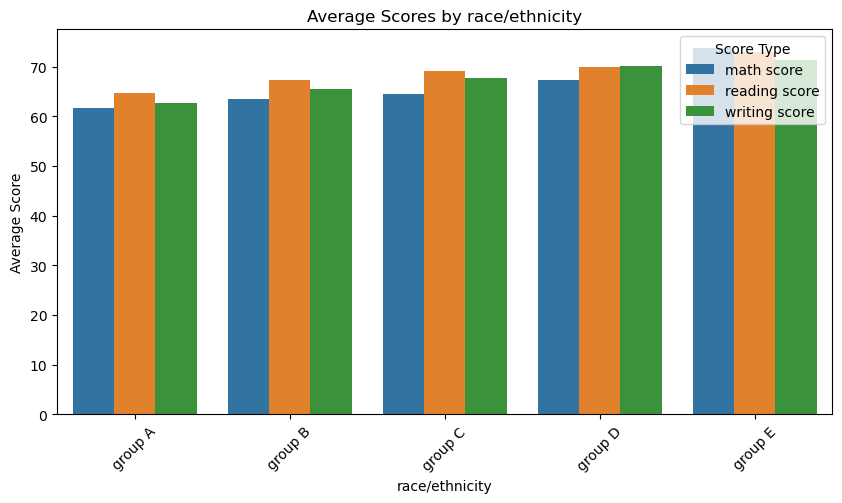

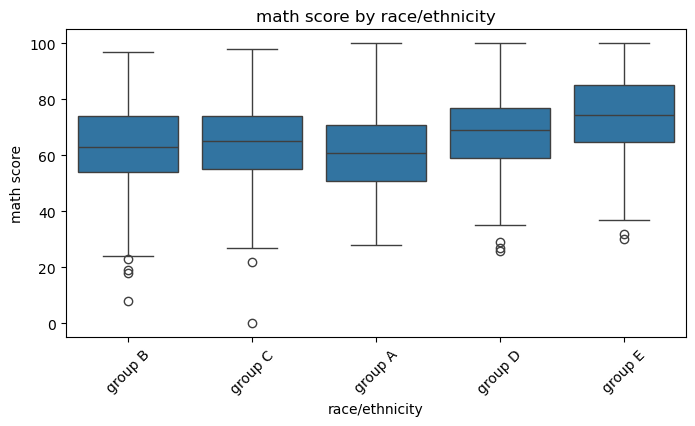

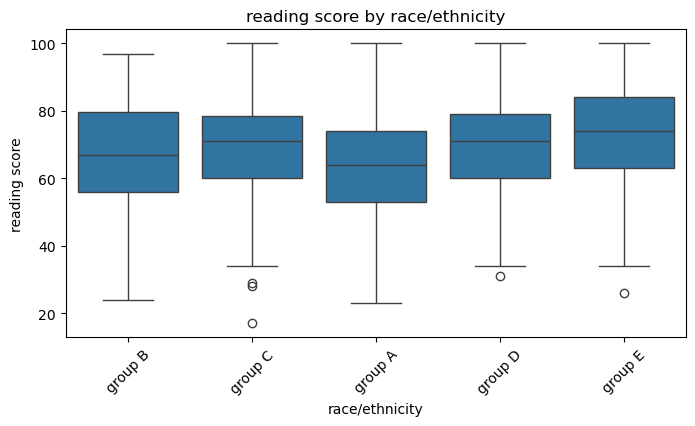

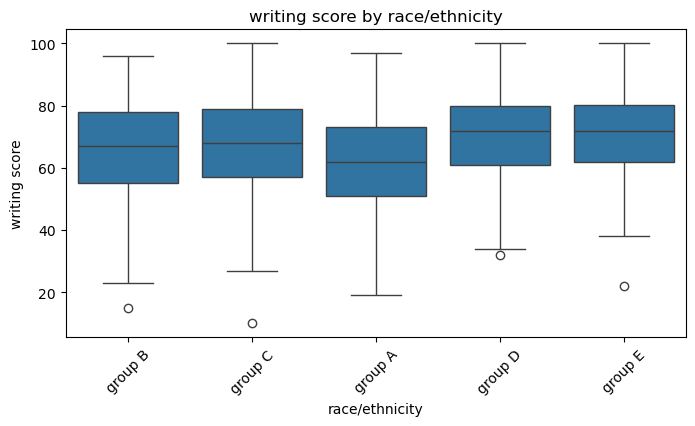


Average scores grouped by parental level of education:


,math score,reading score,writing score
parental level of education,,,
associate's degree,67.882883,70.927928,69.896396
bachelor's degree,69.389831,73.000000,73.381356
high school,62.137755,64.704082,62.448980
master's degree,69.745763,75.372881,75.677966
some college,67.128319,69.460177,68.840708
some high school,63.497207,66.938547,64.888268


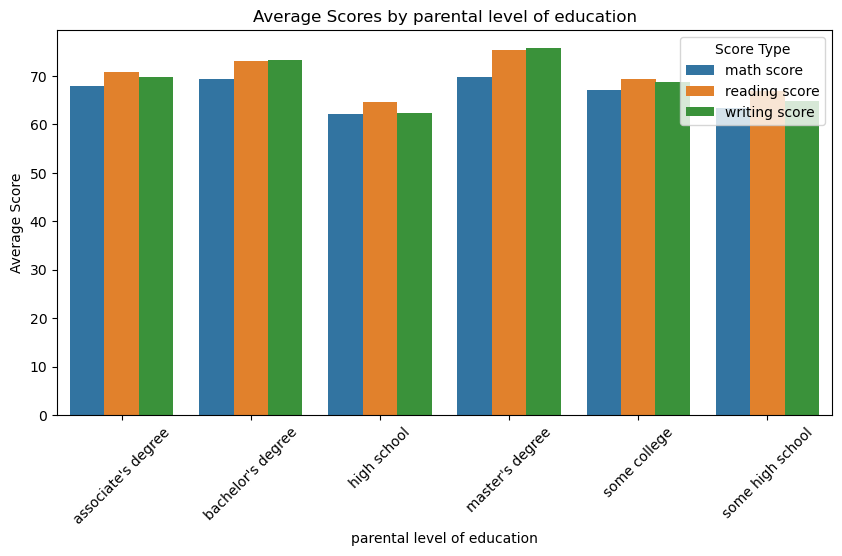

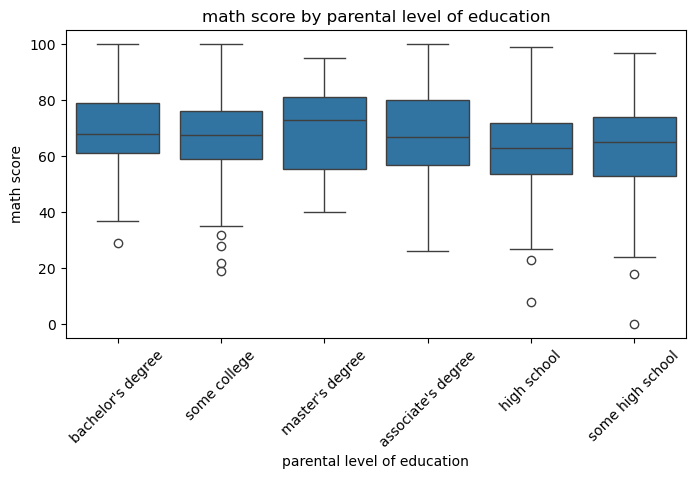

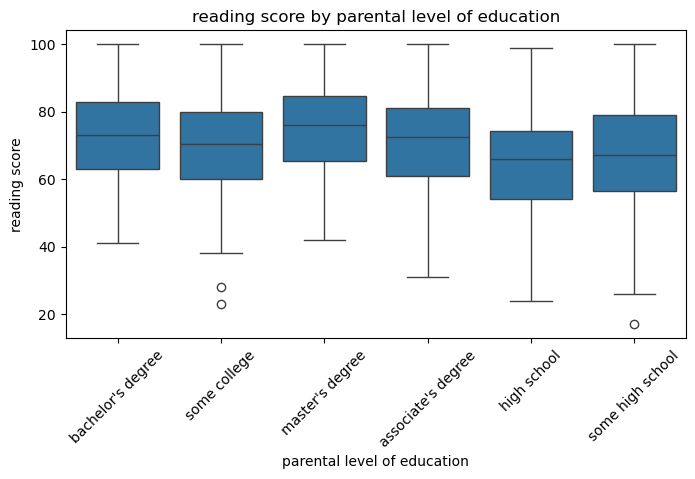

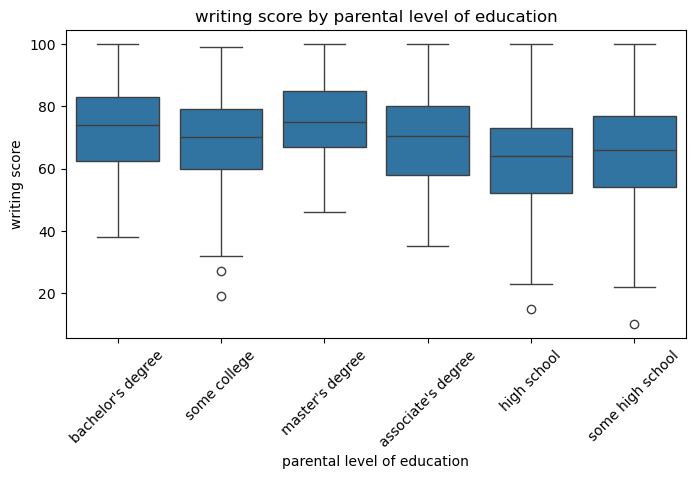


Average scores grouped by lunch:


,math score,reading score,writing score
lunch,,,
free/reduced,58.921127,64.653521,63.022535
standard,70.034109,71.654264,70.823256


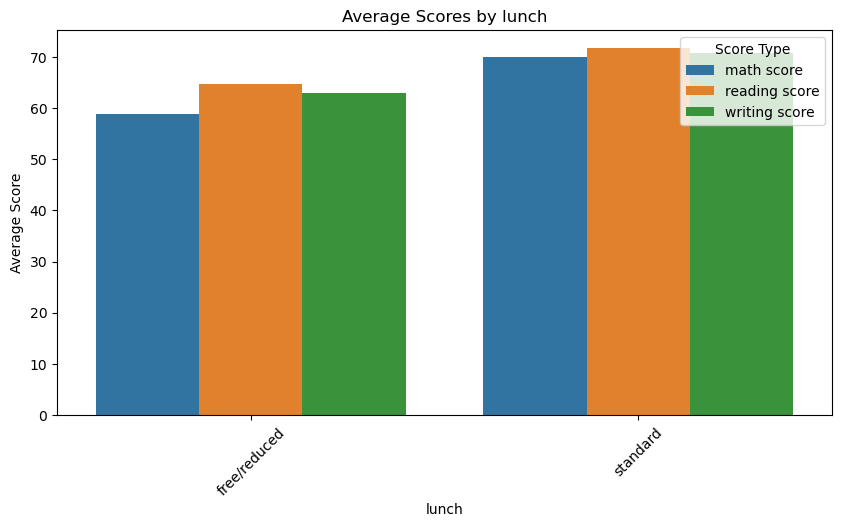

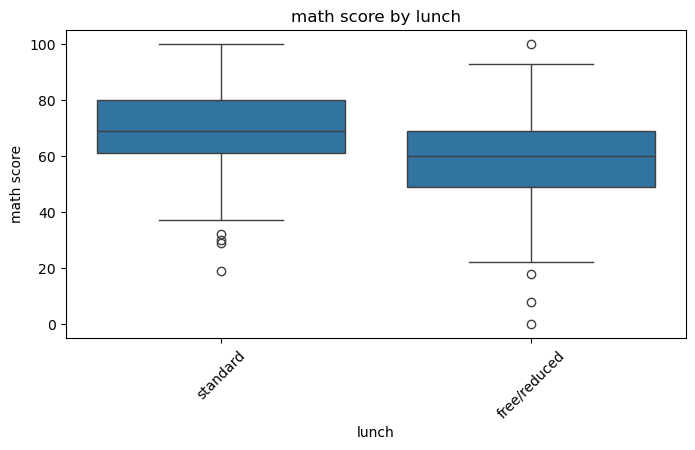

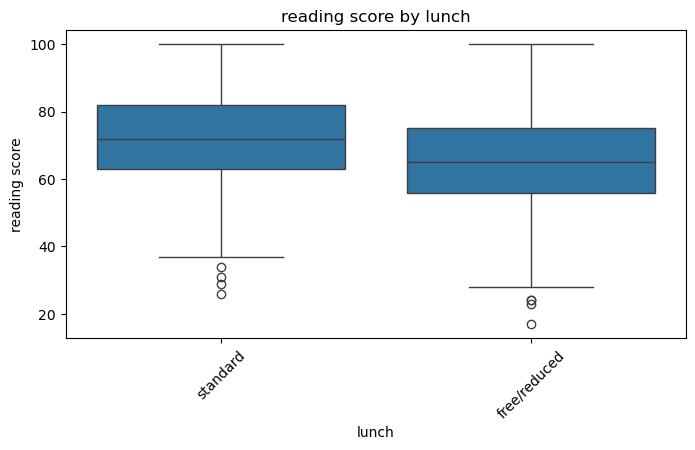

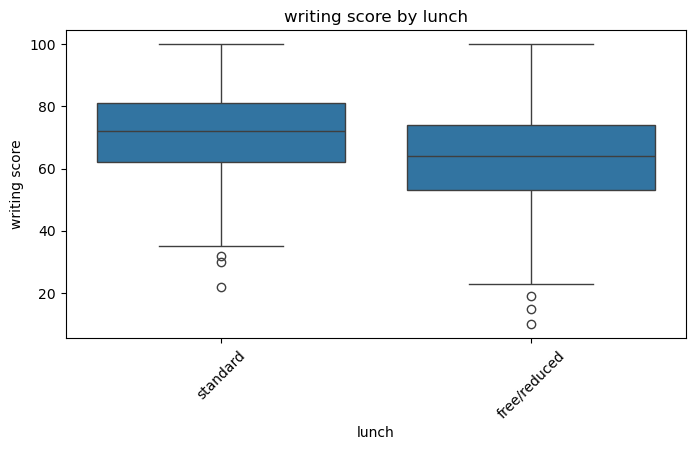


Average scores grouped by test preparation course:


,math score,reading score,writing score
test preparation course,,,
completed,69.695531,73.893855,74.418994
none,64.077882,66.534268,64.504673


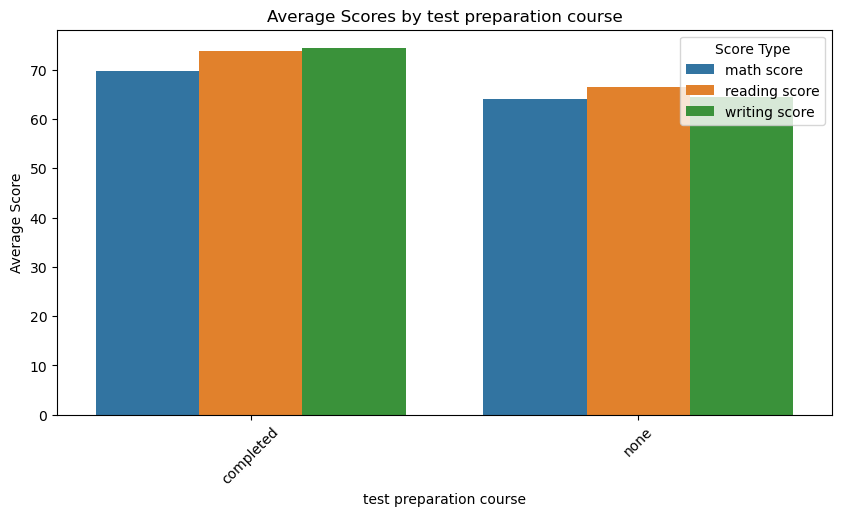

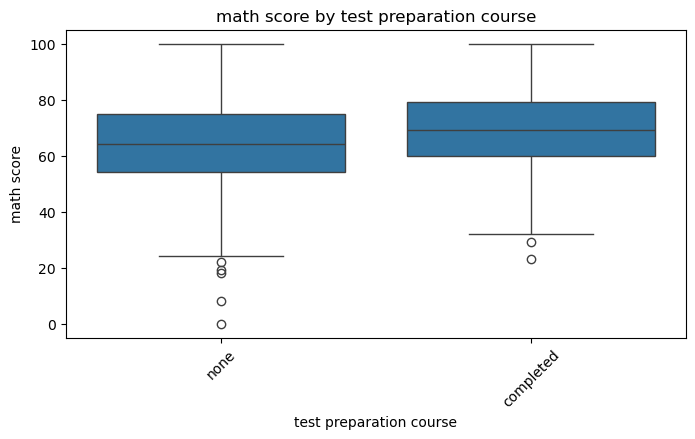

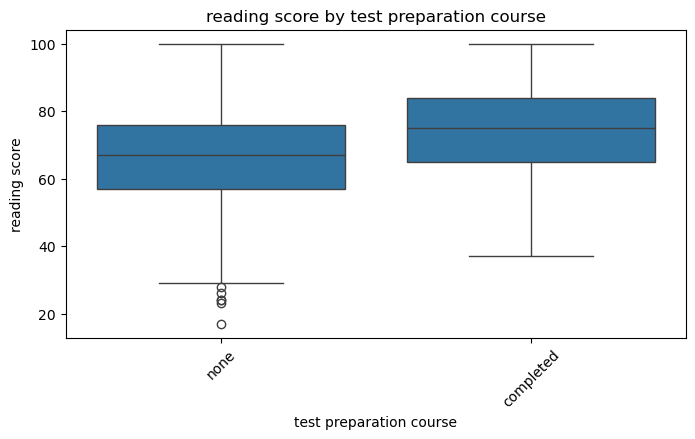

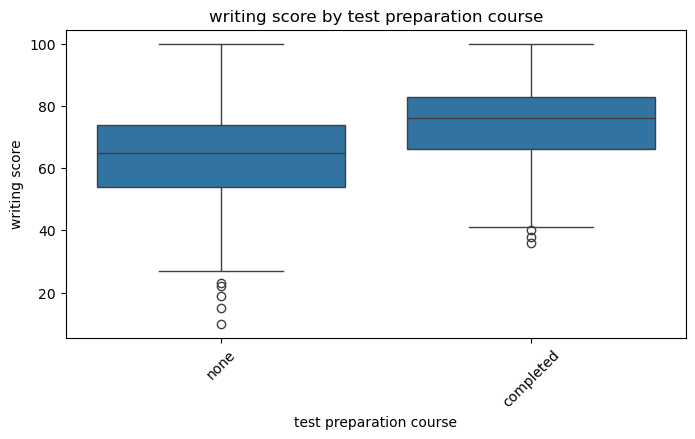

In [8]:
# Analyze scores vs categorical variables: grouped averages and boxplots
for cat in categorical_features:
    print(f'\nAverage scores grouped by {cat}:')
    display(df.groupby(cat)[score_columns].mean())
    df_grouped = df.groupby(cat)[score_columns].mean().reset_index()
    df_grouped_melt = df_grouped.melt(id_vars=cat, var_name='Score Type', value_name='Average Score')
    plt.figure(figsize=(10,5))
    sns.barplot(data=df_grouped_melt, x=cat, y='Average Score', hue='Score Type')
    plt.title(f'Average Scores by {cat}')
    plt.xticks(rotation=45)
    plt.show()
    for score in score_columns:
        plt.figure(figsize=(8,4))
        sns.boxplot(data=df, x=cat, y=score)
        plt.title(f'{score} by {cat}')
        plt.xticks(rotation=45)
        plt.show()

In [9]:
# Identify outliers using z-score
from scipy.stats import zscore
z_scores = np.abs(zscore(df[score_columns]))
outliers = (z_scores > 3).any(axis=1)
print(f'Number of potential outliers: {outliers.sum()}')
display(df[outliers])

Number of potential outliers: 7


,gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
17,female,group B,some high school,free/reduced,none,18,32,28
59,female,group C,some high school,free/reduced,none,0,17,10
76,male,group E,some high school,standard,none,30,26,22
327,male,group A,some college,free/reduced,none,28,23,19
596,male,group B,high school,free/reduced,none,30,24,15
787,female,group B,some college,standard,none,19,38,32
980,female,group B,high school,free/reduced,none,8,24,23


## 4. Data Preprocessing

Encode categorical variables, separate features and targets, and split the data into training and test sets.

In [10]:
# Features and target
X = df[categorical_features]
y = df[score_columns]

# OneHotEncode categorical features
ohe = OneHotEncoder(sparse_output=False, drop='first')
X_encoded = ohe.fit_transform(X)
X_encoded_df = pd.DataFrame(X_encoded, columns=ohe.get_feature_names_out(categorical_features))

# Optionally scale features (not strictly necessary for tree-based models)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_encoded_df)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42
)

print(f'Training set: {X_train.shape}, Test set: {X_test.shape}')

Training set: (800, 12), Test set: (200, 12)


## 5. Model Training

Train and compare LinearRegression, RandomForestRegressor, and GradientBoostingRegressor using MultiOutputRegressor for multi-target regression.

In [11]:
# Train and evaluate models
def evaluate_model(model, X_test, y_test):
    y_pred = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    return {'RMSE': rmse, 'MAE': mae, 'R2': r2}

models = {
    'LinearRegression': MultiOutputRegressor(LinearRegression()),
    'RandomForestRegressor': MultiOutputRegressor(RandomForestRegressor(random_state=42)),
    'GradientBoostingRegressor': MultiOutputRegressor(GradientBoostingRegressor(random_state=42))
}

results = {}
for name, model in models.items():
    model.fit(X_train, y_train)
    results[name] = evaluate_model(model, X_test, y_test)
    print(f'{name} evaluation:', results[name])

LinearRegression evaluation: {'RMSE': np.float64(13.762006966337255), 'MAE': 10.764434560868878, 'R2': 0.19971068034326067}
RandomForestRegressor evaluation: {'RMSE': np.float64(15.200483142052306), 'MAE': 11.815456831939441, 'R2': 0.023839574655047196}
GradientBoostingRegressor evaluation: {'RMSE': np.float64(14.34228614025998), 'MAE': 11.142141765875996, 'R2': 0.1309106156229143}


## 6. Hyperparameter Tuning

Tune RandomForestRegressor and GradientBoostingRegressor using GridSearchCV. Evaluate using RMSE, MAE, and R².

In [12]:
# Hyperparameter tuning for RandomForestRegressor
rf_param_grid = {
    'estimator__n_estimators': [50, 100],
    'estimator__max_depth': [None, 5, 10],
    'estimator__min_samples_split': [2, 5]
}
rf_grid = GridSearchCV(MultiOutputRegressor(RandomForestRegressor(random_state=42)), rf_param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
rf_grid.fit(X_train, y_train)
print('Best RandomForestRegressor params:', rf_grid.best_params_)
rf_best = rf_grid.best_estimator_
rf_eval = evaluate_model(rf_best, X_test, y_test)
print('RandomForestRegressor (tuned) evaluation:', rf_eval)

# Hyperparameter tuning for GradientBoostingRegressor
gb_param_grid = {
    'estimator__n_estimators': [50, 100],
    'estimator__learning_rate': [0.05, 0.1],
    'estimator__max_depth': [3, 5]
}
gb_grid = GridSearchCV(MultiOutputRegressor(GradientBoostingRegressor(random_state=42)), gb_param_grid, cv=3, scoring='neg_mean_squared_error', n_jobs=-1)
gb_grid.fit(X_train, y_train)
print('Best GradientBoostingRegressor params:', gb_grid.best_params_)
gb_best = gb_grid.best_estimator_
gb_eval = evaluate_model(gb_best, X_test, y_test)
print('GradientBoostingRegressor (tuned) evaluation:', gb_eval)

# Update results
tuned_results = results.copy()
tuned_results['RandomForestRegressor (tuned)'] = rf_eval
tuned_results['GradientBoostingRegressor (tuned)'] = gb_eval

Best RandomForestRegressor params: {'estimator__max_depth': 5, 'estimator__min_samples_split': 5, 'estimator__n_estimators': 100}
RandomForestRegressor (tuned) evaluation: {'RMSE': np.float64(14.215659296820549), 'MAE': 11.017784197061253, 'R2': 0.14638131861806855}
Best GradientBoostingRegressor params: {'estimator__learning_rate': 0.05, 'estimator__max_depth': 3, 'estimator__n_estimators': 50}
GradientBoostingRegressor (tuned) evaluation: {'RMSE': np.float64(14.141062831803088), 'MAE': 11.04136561399188, 'R2': 0.15523030069844204}


## 7. Model Comparison

Compare the performance of all models using RMSE, MAE, and R² metrics.

In [13]:
# Model comparison table
comparison_df = pd.DataFrame(tuned_results).T
comparison_df = comparison_df[['RMSE', 'MAE', 'R2']]
display(comparison_df.sort_values('RMSE'))

,RMSE,MAE,R2
LinearRegression,13.762007,10.764435,0.199711
GradientBoostingRegressor (tuned),14.141063,11.041366,0.155230
RandomForestRegressor (tuned),14.215659,11.017784,0.146381
GradientBoostingRegressor,14.342286,11.142142,0.130911
RandomForestRegressor,15.200483,11.815457,0.023840


## 8. Select Best Model

Refit the best-performing model on the entire training set for final use.

In [14]:
# Select and refit the best model
best_model_name = comparison_df['RMSE'].idxmin()
print(f'Best model: {best_model_name}')

if best_model_name == 'RandomForestRegressor (tuned)':
    final_model = rf_best
elif best_model_name == 'GradientBoostingRegressor (tuned)':
    final_model = gb_best
else:
    final_model = models.get(best_model_name, None)

# Refit on all training data
final_model.fit(X_train, y_train)

Best model: LinearRegression


MultiOutputRegressor(estimator=LinearRegression())

## 9. Feature Importance

Plot feature importances for tree-based models (RandomForestRegressor, GradientBoostingRegressor) if applicable.

In [15]:
# Plot feature importances for tree-based models
if hasattr(final_model.estimators_[0], 'feature_importances_'):
    importances = np.mean([est.feature_importances_ for est in final_model.estimators_], axis=0)
    feature_names = ohe.get_feature_names_out(categorical_features)
    feat_imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
    feat_imp_df = feat_imp_df.sort_values('Importance', ascending=False)
    plt.figure(figsize=(10,6))
    sns.barplot(data=feat_imp_df, x='Importance', y='Feature')
    plt.title('Feature Importances')
    plt.show()
else:
    print('Feature importances not available for this model.')

Feature importances not available for this model.


## 10. Gradio Interface

Create a Gradio UI to select a model and input features for prediction.

In [19]:
# Model dictionary
model_dict = {
    'LinearRegression': models['LinearRegression'],
    'RandomForestRegressor': rf_best,
    'GradientBoostingRegressor': gb_best
}

# Preprocessing function
def preprocess_input(gender, race, parental, lunch, prep):
    input_df = pd.DataFrame({
        'gender': [gender],
        'race/ethnicity': [race],
        'parental level of education': [parental],
        'lunch': [lunch],
        'test preparation course': [prep]
    })
    input_encoded = ohe.transform(input_df)
    input_scaled = scaler.transform(input_encoded)
    return input_scaled

# Prediction function
def predict_scores(model_name, gender, race, parental, lunch, prep):
    model = model_dict[model_name]
    X_input = preprocess_input(gender, race, parental, lunch, prep)
    pred = model.predict(X_input)[0]
    return round(pred[0], 2), round(pred[1], 2), round(pred[2], 2)

# Get dropdown options
options = {col: sorted(df[col].unique()) for col in categorical_features}

# Build Gradio UI
with gr.Blocks() as demo:
    gr.Markdown("""
    # 🎓 Student Exam Score Prediction
    **Powered by Scikit-learn & Gradio — by Kuldii Project**

    This application predicts a student's exam performance in **Math**, **Reading**, and **Writing** based on several input factors using different machine learning models.

    ### 📋 Input Features
    - **Gender** — Select the student's gender.
    - **Race/Ethnicity** — Choose from predefined demographic groups.
    - **Parental Level of Education** — Indicate the highest level of education completed by parents.
    - **Lunch Type** — Specify whether the student receives standard or free/reduced lunch.
    - **Test Preparation Course** — Indicate if the student completed a test preparation course.

    ### 🤖 Model Selection
    Choose a regression model to make predictions:
    - **Linear Regression**
    - **Random Forest**
    - **Gradient Boosting**

    Click the **Predict Scores** button after selecting the options to generate the predicted exam scores.
    """)


    with gr.Row():
        model_choice = gr.Dropdown(
            choices=list(model_dict.keys()),
            label="🧠 Select Model",
            value=list(model_dict.keys())[0]
        )

    with gr.Row():
        gender_input = gr.Dropdown(choices=options['gender'], label="👤 Gender")
        race_input = gr.Dropdown(choices=options['race/ethnicity'], label="🌍 Race/Ethnicity")

    with gr.Row():
        parental_input = gr.Dropdown(choices=options['parental level of education'], label="🎓 Parental Education")
        lunch_input = gr.Dropdown(choices=options['lunch'], label="🍽️ Lunch Type")

    with gr.Row():
        prep_input = gr.Dropdown(choices=options['test preparation course'], label="📘 Test Preparation")

    predict_btn = gr.Button("📈 Predict Scores")

    with gr.Row():
        math_output = gr.Number(label="📊 Predicted Math Score")
        reading_output = gr.Number(label="📖 Predicted Reading Score")
        writing_output = gr.Number(label="✍️ Predicted Writing Score")

    predict_btn.click(
        fn=predict_scores,
        inputs=[model_choice, gender_input, race_input, parental_input, lunch_input, prep_input],
        outputs=[math_output, reading_output, writing_output]
    )

demo.launch()


* Running on local URL:  http://127.0.0.1:7863
* To create a public link, set `share=True` in `launch()`.


In [ ]:
import os
import joblib

# ---------------------------------------------
# Buat folder jika belum ada
# ---------------------------------------------
model_dir = "models"
os.makedirs(model_dir, exist_ok=True)

# ---------------------------------------------
# Simpan model individual (opsional)
# ---------------------------------------------
# joblib.dump(models['LinearRegression'], os.path.join(model_dir, 'linear_regression.pkl'))
# joblib.dump(rf_best, os.path.join(model_dir, 'random_forest.pkl'))
# joblib.dump(gb_best, os.path.join(model_dir, 'gradient_boosting.pkl'))

# ---------------------------------------------
# Simpan semua model ke dalam satu dictionary
# ---------------------------------------------
model_dict = {
    'LinearRegression': models['LinearRegression'],
    'RandomForestRegressor': rf_best,
    'GradientBoostingRegressor': gb_best
}
joblib.dump(model_dict, os.path.join(model_dir, 'student_models.pkl'))

# ---------------------------------------------
# Simpan preprocessing tools dan dropdown options ke dalam satu file
# ---------------------------------------------
preprocessors = {
    'encoder': ohe,
    'scaler': scaler,
    'options': {col: sorted(df[col].unique()) for col in categorical_features}
}
joblib.dump(preprocessors, os.path.join(model_dir, 'preprocessors.pkl'))

print("✅ All models and preprocessors saved successfully.")


✅ All models and preprocessors saved successfully.
